# Obtaining the MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame=False)

In [2]:
X, y = mnist.data, mnist.target

In [3]:
print(f"Shape of the training data: {X.shape}")

Shape of the training data: (70000, 784)


In [4]:
# Utility function to print an image from the dataset
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [5]:
random_digit_idx = 123
random_digit = X[random_digit_idx]
print(f"random_digit looks like this: {random_digit.shape}")
print("There is one row 784 values. Each value represents the intensity of a specific pixel.")

random_digit looks like this: (784,)
There is one row 784 values. Each value represents the intensity of a specific pixel.


The image looks like the below, and based on the label it is actually a 7


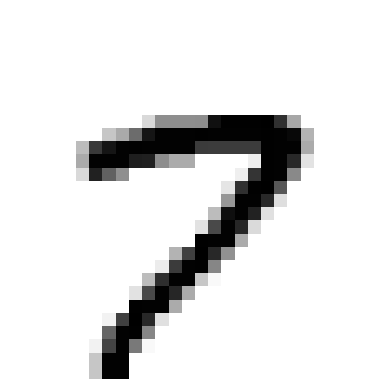

In [6]:
plot_digit(random_digit)
print(f"The image looks like the below, and based on the label it is actually a {y[123]}")

In [7]:
# Splitting into training and test set
# MNIST automatically handles the shuffling and any stratification by default
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier (7 or Not 7)

In [8]:
y_train_7 = (y_train == '7')
print(y_train_7.shape) # we see that it maintains the same shape, but just has false 
# for every instance that is not a 7

idx_7 = []
idx_not_7 = []
for i in range(len(y_train_7)):
    if y_train_7[i] == True:
        idx_7.append(i)
    else:
        idx_not_7.append(i)

print(f"Total number of 7s: {len(idx_7)}")
print(f"Total number of not 7s: {len(idx_not_7)}")

(60000,)
Total number of 7s: 6265
Total number of not 7s: 53735


### How a Stochastic Gradient (SGD) classifier works
- Computes a score based on a decision function.
- If that score is greater than some threshold, it assigns the instance to the positive class. 
- Otherwise, it assigns the negative class.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_7)
# 7 will be the positive class 

SGDClassifier(random_state=42)

In [10]:
# Testing if the model can correctly identify our random digit
print(f"The model identifies our random_digit as:\
 {'7' if sgd_clf.predict([random_digit]) == False else 'Not 7.'}")

print(f"The random digit is actually a {y_train[random_digit_idx]}")

The model identifies our random_digit as: Not 7.
The random digit is actually a 7


In [11]:
# Incorrect result for the random digit, so let us try a few more.
import numpy as np

rand_idxs = np.random.randint(1, 60000, size=20) #generate 20 random from the train set
for rand_idx in rand_idxs:
    if sgd_clf.predict([X_train[rand_idx]])[0] == False:
        print(f"Model prediction: Not a 7.")
    else:
        print(f"Model Prediction: 7")
    print(f"This instance is actually a: {y_train[rand_idx]}")
    print('*'*50)

Model prediction: Not a 7.
This instance is actually a: 9
**************************************************
Model prediction: Not a 7.
This instance is actually a: 8
**************************************************
Model prediction: Not a 7.
This instance is actually a: 8
**************************************************
Model prediction: Not a 7.
This instance is actually a: 2
**************************************************
Model prediction: Not a 7.
This instance is actually a: 6
**************************************************
Model prediction: Not a 7.
This instance is actually a: 8
**************************************************
Model prediction: Not a 7.
This instance is actually a: 1
**************************************************
Model prediction: Not a 7.
This instance is actually a: 5
**************************************************
Model prediction: Not a 7.
This instance is actually a: 4
**************************************************
Model prediction: N

# Measuring Accuracy Using Cross-Validation
- At a glance, the model does not seem to be doing too poorly. 
- But we can use cross validation to get a measure of the accuracy.

In [12]:
from sklearn.model_selection import cross_val_score

# Use 3 folds to 
accuracy_scores = cross_val_score(sgd_clf, X_train, y_train_7, cv=3, scoring='accuracy')

In [13]:
print("SGD Classifier:")
for i in range(len(accuracy_scores)):
    print(f"- Fold {i+1} accuracy: {round(accuracy_scores[i]*100, 2)}%")

SGD Classifier:
- Fold 1 accuracy: 98.1%
- Fold 2 accuracy: 97.35%
- Fold 3 accuracy: 95.34%


## The Potential Problem with the Accuracy Metric
- >95% accuracy makes it seem like the model is performing really well.
- However, this just gives the percentage of classifications that are correct. 
- But, as shown below, the DummyClassifier ALWAYS predicts negative. Since only a small percentage of the 60,000 instances are 7s (10.44%), predicting False (value not a 7) will be correct the vast majority of the time.

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_7)
print(any(dummy_clf.predict(X_train))) # Check if any items in the list are true

# Evaluate the dummy classifier (which always predicts false) 's accuracy
dummy_accuracy_scores = cross_val_score(dummy_clf, X_train, y_train_7, cv=3, scoring='accuracy')


False


In [15]:
print("Dummy Classifier:")
for i in range(len(dummy_accuracy_scores)):
    print(f"- Fold {i+1} accuracy: {round(dummy_accuracy_scores[i]*100, 2)}%")

Dummy Classifier:
- Fold 1 accuracy: 89.56%
- Fold 2 accuracy: 89.56%
- Fold 3 accuracy: 89.56%


# Confusion Matrices
- In a binary classification context, a confusion matrix will show the number of:
    - True Positives (TP)
    - False Positives (FP)
    - True Negatives (TN)
    - False Negatives (FN)

In [16]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns the PREDICTIONS made on each fold (instead of the score)
y_train_7_predictions = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3)

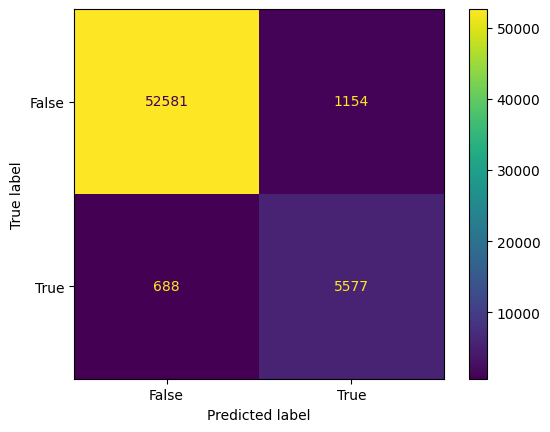

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train_7, y_train_7_predictions)
plt.show()

In the matrix above, we can see that the model identified:
- 52,581 digits that are not 7s as 7s
- 1154 digits that are actually not 7s as 7s
- 688 digits that are 7s as not 7s
- 5577 digits that are 7s as 7s

## Precision and Recall
- Because accuracy is not always the best measure, we use precision and recall.
- **Precision**:
    - *In English*: The accuracy of the positive predictions.
    - If the model predicts that the instance is positive, what is the likelihood that this prediction is correct.
    - Calculated by: $ \frac{TP}{TP + FP} $
- **Recall**:
    - *In English*: The ratio of actually positive instances that are identified as such.
    - If an item is of the positive class, how likely is it that the model detected it as such.
    - Calculated by: $ \frac{TP}{TP + FN} $

- The choice of whether to prefer a high **precision** or a high **recall** depends on the speicifc project. Examples:
    - Spam filter to detect spam emails:
        - It would be preferable to let a few spam messages end up in the inbox than to have a very important email misclassified as spam. Therefore, a high **precision** would be preferred. We need to make sure that we cna be really confident IF the classifier classes this as spam, then it is actually spam.
    - Medical diagnostic tool to identify cases of a rare but serious disease:
        - It would be preferable to misdiagnose someone as *having* the disease, than to have someone who actually has the disease being diagnosed as not having it. Someone who is incorrectly classed as having the disease will likely catch this in subsequent tests. So a high **recall** is preferred.
    - A search engine which you only want to display results relevant to the user's query:
        - It is more important that if a result is returned, it is actually relevant to the user's query than it is to ensure we capture EVERY possible relevant result. High **precision** is preferred here. 
    

In [18]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision Score of `7 or not 7` model: \
{round(precision_score(y_train_7, y_train_7_predictions) * 100, 2)}%")

print(f"Recall Score of `7 or not 7` model: \
{round(recall_score(y_train_7, y_train_7_predictions) * 100, 2)}%")

Precision Score of `7 or not 7` model: 82.86%
Recall Score of `7 or not 7` model: 89.02%


To translate these results:
- When our classifier claims a digit is a 7%, we can be 82.86% sure it is correct.
- Our classifier correctly detects 89.02% of all 7s.

## $F_1$ Score
- This is the harmonic mean of the precision and recall. 
- Whereas the regular mean treats all values equally, the harmonix mean gives much more weight to low values.
- The classifier will only get a high $F_1$ score if both precision and recall are high. The challenge with this, though, is that increasing precision reduces recall and vice-versa. There is a tradeoff. 

In [19]:
from sklearn.metrics import f1_score

print(f"F1 score of `7 or not 7 model: \
{round(f1_score(y_train_7, y_train_7_predictions) * 100, 2)}%")

F1 score of `7 or not 7 model: 85.83%


## How the Stochastic Gradient Descent (SGD) classifier works
1. It computes a score based on a decision function.
2. If that score is greater than a threshold, it assigns the instance to the positive class.
3. Otherwise, it assigns the negative class.

In [20]:
random_digit_decision_score = sgd_clf.decision_function([random_digit])
print(f"The score for our random digit is: {random_digit_decision_score[0]}")

The score for our random digit is: 8840.523290066285


- This means that once our score is greater than the threshold of 8840, the digit will be classified as a 7. 
- We can see that increasing the threshold would increase **precision**. i.e. only numbers that the model is EXTREMELY certain is a 7, will get classified as a 7. 
- Conversely, this will decrease recall, as it is likely some of the less certain digits will be classified as not a 7. 

In [21]:
threshold = 8000
# True if the score for the random digit is greater than the threshold
random_digit_prediction = (random_digit_decision_score > threshold)
print(random_digit_prediction)


[ True]


In [22]:
# Using cross validation to return the decision scores of the sgd classifier
y_decision_scores = cross_val_predict(sgd_clf, X_train, y_train_7, 
    cv=3, method='decision_function')

# y_decision_scores contains the decision score for each instance in X_train
# Those instances with a decision score over the specified threshold will be
# classified as 7s.

print(y_decision_scores)

[-26444.17375986 -29232.36194438 -24011.8285088  ... -24767.21328011
 -18076.58386084 -12330.55080778]


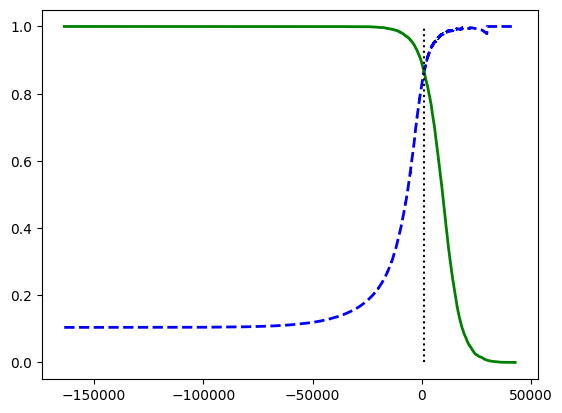

In [23]:
# We now want to plot a precision_recall_curve to plot the precision and 
# recall values for a number of different possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_7, 
    y_decision_scores)

threshold = 1000

# Defining the plot
# Precision line is blue dashed
# Recall line is green
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

From the graph above, we can see that our threshold of 1000 yields high precision and recall values.

In [24]:
print(f"Total Precisions: {len(precisions)}")
print(f"Total Recalls: {len(recalls)}")
print(f"Total Thresholds: {len(thresholds)}")
print('*'*50)
for i in range(0, len(thresholds), 1000):
    print(f"Threshold: {thresholds[i]}")
    print(f"Precision: {round(precisions[i] * 100, 2)}%")
    print(f"Recall: {round(recalls[i] * 100, 2)}%")
    print('*'*20)

Total Precisions: 60001
Total Recalls: 60001
Total Thresholds: 60000
**************************************************
Threshold: -163657.52830886433
Precision: 10.44%
Recall: 100.0%
********************
Threshold: -81015.96720255725
Precision: 10.62%
Recall: 100.0%
********************
Threshold: -70793.14331035539
Precision: 10.8%
Recall: 100.0%
********************
Threshold: -65066.192800157885
Precision: 10.99%
Recall: 100.0%
********************
Threshold: -60566.56078959194
Precision: 11.19%
Recall: 100.0%
********************
Threshold: -56938.208947179235
Precision: 11.39%
Recall: 99.98%
********************
Threshold: -54038.64683866656
Precision: 11.6%
Recall: 99.98%
********************
Threshold: -51329.593323222616
Precision: 11.82%
Recall: 99.98%
********************
Threshold: -49022.94080152814
Precision: 12.05%
Recall: 99.98%
********************
Threshold: -46868.67394412033
Precision: 12.28%
Recall: 99.98%
********************
Threshold: -45046.058687970304
Precisi

In [25]:
# Since for this task it is more important to have accurate results than 
# to ensure we pick up every single 7, let us prioritize a high precision.
# We can search for the lowest threshold that gives us at least 90% precision.
# We choose the lowest so that we don't have to go too high and sacrifice recall.
# Remember increasing the threshold will decrease recall

idx_for_90_precision = (precisions >= 0.9).argmax()
print(f"Index {idx_for_90_precision} is the lowest index that has a precision\
 of at least 90%.") 
print(f"The threshold at this index is {thresholds[idx_for_90_precision]}")
print(f"The precision at this threshold is {round(precisions[idx_for_90_precision] * 100, 2)}%")
print(f"The recall at this threshold is {round(recalls[idx_for_90_precision] * 100, 2)}%")


Index 54215 is the lowest index that has a precision of at least 90%.
The threshold at this index is 2288.724768166237
The precision at this threshold is 90.01%
The recall at this threshold is 83.11%


In [26]:
threshold_for_90_precision = thresholds[idx_for_90_precision]

# This returns True for any instance where the decision score is greater than 
# the threshold we identified that gives us a precision of 90% across the dataset
y_train_pred_90_precision = (y_decision_scores >= threshold_for_90_precision)

# Precision calculated by checking how this model performed against the actual labels
print(f"Precision: {precision_score(y_train_7, y_train_pred_90_precision)}")
print(f"Recall: {recall_score(y_train_7, y_train_pred_90_precision)}")

Precision: 0.9000864304235091
Recall: 0.8311252992817239


# The ROC Curve
- The *receiver operating characteristic* (ROC) curve is another common tool used to evaluate binary classifiers. 
- It plots the *true positive rate* (precision) against the *false positive rate* (FPR) (fall-out).
- The **fall-out** is the ratio of negative instances that are incorrectly classified as positive. 
    - This is calculated as $ 1 -$ specifity.
- **Specifity** is the *true negative rate* (TPR): the ratio of negative instances that are correctly classified. 
- Therefore, the ROC curve plots **recall** against $1 -$ specificity.
- It shows how well a classifer separates negative and positive classes by showing the tradeoff between TPR and FPR. 

In [27]:
from sklearn.metrics import roc_curve

false_pos_rates, true_pos_rates, thresholds = roc_curve(y_train_7, y_decision_scores)

In [28]:
# With the roc_curve, thresholds are listed in descending order
# So the following code returns the index of the smallest threshold that gives
# us a precision of 90
idx_for_90_precision = (thresholds <= threshold_for_90_precision).argmax()
print(f"The index of the threshold that gives us 90% precision is: {idx_for_90_precision}")

The index of the threshold that gives us 90% precision is: 880


In [29]:
false_pos_rate_90 = false_pos_rates[idx_for_90_precision]
true_pos_rate_90 = true_pos_rates[idx_for_90_precision]

print(f"The false positive rate at this index (this threshold value) is: {false_pos_rate_90}")
print(f"The true positive rate at this index (this threshold value) is: {true_pos_rate_90}")


The false positive rate at this index (this threshold value) is: 0.010756490183306969
The true positive rate at this index (this threshold value) is: 0.8311252992817239


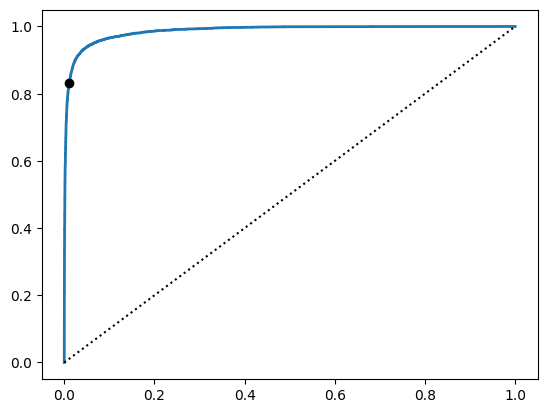

In [30]:
# Similar to the plot we did to see what precision and recall look like at 
# different threshold values, we can plot the ROC curve
plt.plot(false_pos_rates, true_pos_rates, linewidth=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k:", label="Random classifier ROC Curve")
plt.plot([false_pos_rate_90], [true_pos_rate_90], "ko", label="Threshold for 90% precision")
plt.show()

C:\Users\Tevin.Achong\AppData\Local\Temp\ipykernel_8500\1317865816.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label="Random guessing (AUC = 0.5)", color="red")


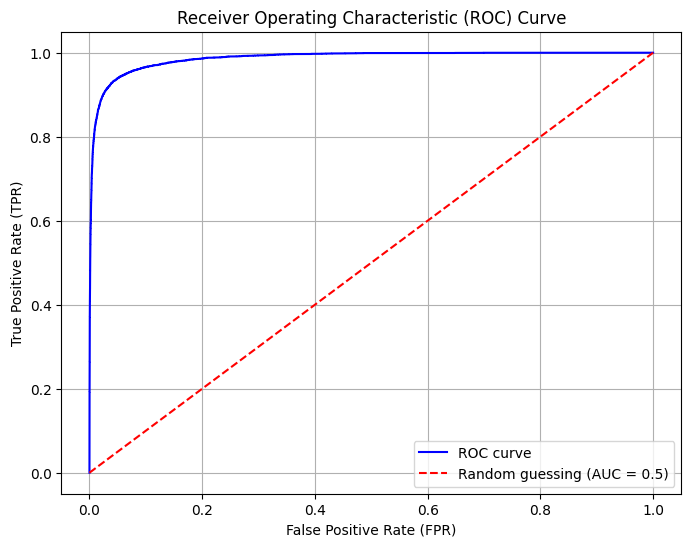

In [31]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_pos_rates, true_pos_rates, label=f"ROC curve", color="blue")
plt.plot([0, 1], [0, 1], 'k--', label="Random guessing (AUC = 0.5)", color="red")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

## Area Under the ROC Curve (AUC-ROC)
- This gives a single number summary of how well a classifier is able to distinguish between classes.
    - AUC = 1.0 = Perfect classifier
    - AUC = 0.5 = Completely random classifier

In [32]:
from sklearn.metrics import roc_auc_score
auc_score_7 = roc_auc_score(y_train_7, y_decision_scores)

print(f"The area under the curve for our 7 or not-7 classifier is: \
{round(auc_score_7, 2)}")

The area under the curve for our 7 or not-7 classifier is: 0.99


## Deciding Between ROC Curve and Precision-Recall Curve
| **Scenario** | **Metric to Use** | **Reason** |
| -------- | ------------- | ------ |
| Balanced dataset | AUC-ROC | Measures overall ranking performance between datasets |
| Imbalanced dataset | Precision-Recall Curve | Focuses on performance for the minority class |
| Optimizing for both precision & recall | $F_1$ Score | Provides a single score balancing precision and recall |
| Comparing models over all thresholds | AUC-ROC or AUC-PR | Summarizes model performance across thresholds |
| Threshold-independent evaluation | AUC-ROC or AUC-PR | Works without committing to a specific decision threshold |
| Minimizing false negatives | Recall or Precision-Recall | Ensures you capture most positive cases |
| Minimizing false positives | Precision or $F_1$ score | Ensures predictions flagged as positive are mostly correct |


In [33]:
# Create a Random Forest Classifier whose PR curve and F1 score we can compare
# to the SGD classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [34]:
# Random forest returns probability of an instance being in each class
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_7,
cv=3, method="predict_proba")

### Interpreting output of a random forest classifier
- For each prediction:
    - The first index of the prediction is the probability that the instance is not in the positive class.
    - The second index of the prediction is the probability that the instance is in thet positive class. 
- So for our "7 or not-7" classifier, a prediction of `[0.2, 0.98]` is the model telling us that there is a 2% probability that this instance is not a 7, and a 98% probability that this instance is a 7. 

In [35]:
# Using our random digit as an example
rand_digit_pred_forest = y_probs_forest[random_digit_idx]

print(f"Our random digit is {'a ' if y_train_7[random_digit_idx] == True else 'not a '}7.")
print("Our model predictions: ")

print(f"Probability that the random digit is not a 7: \
{round(rand_digit_pred_forest[0] * 100, 2)}%")

print(f"Probability that the random digit is a 7: \
{round(rand_digit_pred_forest[1] * 100, 2)}%")


Our random digit is a 7.
Our model predictions: 
Probability that the random digit is not a 7: 2.0%
Probability that the random digit is a 7: 98.0%


In [36]:
# Just the probabilities of the positive class
y_probs_forest_pos = y_probs_forest[:, 1]

In [37]:
precisions_forest, recalls_forest, thresholds_forest = \
    precision_recall_curve(y_train_7, y_probs_forest_pos)

The question I had: How come we can rate the model's performance using the above code even though `y_probs_forest_pos` is a list of decimal values and `y_train_7` is a list of boolean values? How we would we know if a prediction is "correct" ?

Explanation:
- `precision_recall_curve(y_train_7, y_probs_forest_pos)` evaluates a value of `True` or `False` for every instance of `y_probs_forest_pos`.
- The evaluation is done based on some threshold: if the decimal value of this instance is greater than the threshold, then we return `True`, otherwise `False`. 
- For example, if the threshold is 0.4 and the model is 39% sure that this instance is positive, then we return `False`.
- So the function ultimately returns a precision and a recall score for various threshold values.
- We can then use this info to decide where we want to set our threshold.

In [38]:
print("Comparing the SGD classifier to the RandomForest Classifier.")

print(f"SGD Classifier AUC for the ROC Curve: \
{round(roc_auc_score(y_train_7, y_decision_scores), 5)}")

print(f"RandomForest Classifier AUC for the ROC Curve: \
{round(roc_auc_score(y_train_7, y_probs_forest_pos), 5)}")

Comparing the SGD classifier to the RandomForest Classifier.
SGD Classifier AUC for the ROC Curve: 0.98667
RandomForest Classifier AUC for the ROC Curve: 0.99827


# Multiclass Classification
- This is where a model needs to classify input data into one of three or more categories. 
- Example for MNIST: if the digit is a 1, 2, 3, 4, 5, 6, 7, 8, 9 or 0. 
- There are two (2) main strategies:
    - *One-versus-all (OvA)* or *One-versus-the-rest (OvR)*:
        - Train one binary classifier for each of the possible classes.
        - Get the decision score from each binary classifier and select the classifier with the highest score. 
    - *One-versus-one (OvO)*:
        - Train a binary classifier for each **pair** of classes.
        - This requires $ \frac{N \times (N - 1)}{2} $ classifiers to be trained.
        - Some algorithms (such as SVMs) scale poorly with the size of the training set. 
        - OvO is preferred for these because it is faster to train many classifiers on small training sets than it is to train a few classifiers on large training sets.

### Multiclass Classification with a Support Vector Classifier

In [39]:
# Multiclass Classification with a Support Vector Classifier
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
# Use only the first 2000 instances of the training set for speed
svm_clf.fit(X_train[:2000], y_train[:2000]) 

SVC(random_state=42)

- Under the hood, since there are 10 classes, the SVC trained $ \frac{10 \times 9}{2} = \frac{90}{2} = 45 $ classifiers using the *OvO* strategy.
- To make a prediction for a particular instance, it selects the class that has won the most duels.

In [40]:
svm_rand_pred = svm_clf.predict([random_digit])[0]
print(f"The SVM Classifier predicts that the random digit is a: {svm_rand_pred}")

The SVM Classifier predicts that the random digit is a: 7


In [41]:
# We can check the decision scores that the SVM Classifier predicted
# for all classes for the random digit
svm_rand_digit_scores = svm_clf.decision_function([random_digit])
print("SVM Classifier Decision Scores for Each Class:")
for i in range(len(svm_rand_digit_scores[0])):
    print(f"\tClass {i}: {svm_rand_digit_scores[0][i]}")

SVM Classifier Decision Scores for Each Class:
	Class 0: 4.87424631591906
	Class 1: -0.28598225815108014
	Class 2: 5.978483144221533
	Class 3: 2.776087792123156
	Class 4: 5.862372454724969
	Class 5: 4.866873986208835
	Class 6: 0.7129978577020076
	Class 7: 9.30902928998108
	Class 8: 1.7493378870906073
	Class 9: 8.289705687802464


- We can see there are 10 scores: one score per class.
- Each class gets a score equal to the number of won duels $+ / -$ a small tweak to break ties.
- The highest score is for class 7, therefore, the model categorizes it as a 7.

In [42]:
# If we wanted to manually get the predicted class based on the decision score
prediction_class_idx = svm_rand_digit_scores.argmax()
print(f"The index of the highest decision score when the random digit is used \
as input to our SVM Classifier is: {prediction_class_idx}")

# When a classifier is trained in sklearn, it returns an attribute "classes_"
print(f"All the classes our SVM Classifier trained on: {svm_clf.classes_}")

# So if we pass the index of the highest decision score to "classes_", we will
# get the predicted class
print(f"Therefore, the predicted class is: {svm_clf.classes_[prediction_class_idx]}")

The index of the highest decision score when the random digit is used as input to our SVM Classifier is: 7
All the classes our SVM Classifier trained on: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Therefore, the predicted class is: 7


### Multiclass Classification with a Stochastic Gradient Classifier

In [43]:
# Training an SGD Classifier to identify a digit's class
sgd_clf = SGDClassifier(random_state=42)
# Use only the first 2000 instances for speed
sgd_clf.fit(X_train[:2000], y_train[:2000])

SGDClassifier(random_state=42)

In [44]:
sgd_rand_pred = sgd_clf.predict([random_digit])[0]
print(f"The SGD classifier predicts that the random digit is a: {sgd_rand_pred}")

The SGD classifier predicts that the random digit is a: 7


In [45]:
# We can check the decision scores that the SGD Classifier predicted
# for all classes for the random digit
sgd_rand_digit_scores = sgd_clf.decision_function([random_digit])
print("SGD Classifier Decision Scores for Each Class:")
for i in range(len(sgd_rand_digit_scores[0])):
    print(f"\tClass {i}: {sgd_rand_digit_scores[0][i]}")

SGD Classifier Decision Scores for Each Class:
	Class 0: -628367.3225296009
	Class 1: -1962094.1005943296
	Class 2: -2683138.2043732055
	Class 3: -1283378.5690427008
	Class 4: -2082171.1216411807
	Class 5: -1112786.8829963254
	Class 6: -4130445.3910239716
	Class 7: 1231992.4397594347
	Class 8: -390039.31679037085
	Class 9: -87744.17807371965


In [46]:
# Gauging the accuracy of the SVM vs the SGD classifier
cv = 3
svm_cross_val = cross_val_score(svm_clf, X_train, y_train, cv=cv, scoring="accuracy")
sgd_cross_val = cross_val_score(sgd_clf, X_train, y_train, cv=cv, scoring="accuracy")
print(f"Across {cv} folds, the SVM classifier has an accuracy of: {svm_cross_val}")
print(f"Across {cv} folds, the SGD classifier has an accuracy of: {sgd_cross_val}")

Across 3 folds, the SVM classifier has an accuracy of: [0.977  0.9738 0.9739]
Across 3 folds, the SGD classifier has an accuracy of: [0.87365 0.85835 0.8689 ]


In [47]:
# Since at their bases, the SVM classifier performs better than the SGD, we proceed with the SVM classifier
# Standardizing the inputs to gauge the impact on accuracy
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
svm_cross_val_std = cross_val_score(svm_clf, X_train_scaled, y_train, cv=cv, scoring="accuracy")
print(f"Across {cv} folds, the SGD classifier, with standardized input, has an accuracy of: {svm_cross_val_std}")

Across 3 folds, the SGD classifier, with standardized input, has an accuracy of: [0.9596 0.9602 0.961 ]


In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

# Getting predictions from the SGD Classifier that uses scaled values as input
y_train_pred = cross_val_predict(svm_clf, X_train_scaled, y_train, cv=3)


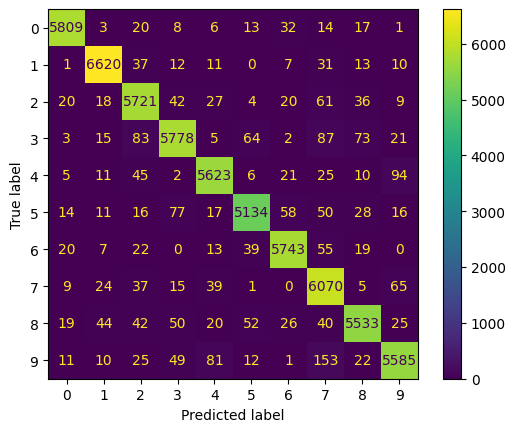

In [49]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

- By default, the confusion matrix shows the absolute number of classifications, at a glance we may see that the biggest issue seems to be digits being misclassified as 7s. 
- Since absolute values can sometimes be misleading, we can instead show the predictions by percentage.

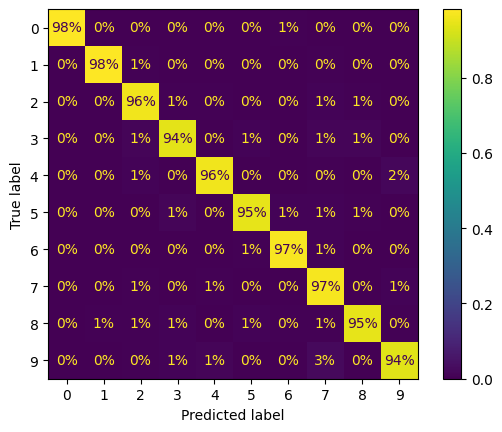

In [50]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

- Above, we can see that, for example, of all the predictions made on digits that were actually 9s, 94% were classified as 0s (correctly), 1% as 3, 1% as 4 and 3% as 7. 

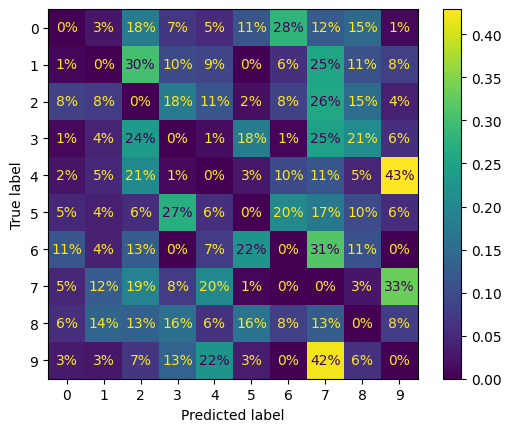

In [51]:
# Putting zero weight on the correct predictions to properly highlight erroneous predictions
sample_weight = (y_train_pred != y_train) #true where the prediction is incorrect
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_pred,
    sample_weight=sample_weight,
    normalize='true', values_format='.0%'
)
plt.show()

### Explaining the diagram above
- Since we only return true if the prediction is incorrect, the matrix above shows where each label has the highest percentage of misclassification.
- e.g. Of all the misclassifications made on 4s, 43% of them were misclassified as 9s.

- Some further insights based on the image above -> if they are misclassified:
    - 0 is mostly mistaken for 6, 2, or 8
    - 1 for 2, or 7
    - 2 for 7 or 3
    - 3 for 7 or 2
    - 4 for 9 (big problem) or 2
    - 5 for 3 or 6
    - 6 for 7 or 5
    - 8 for 9 or 4
    - 9 for 7 (big problem) or 4

## Multilabel Classification
- In some cases, you may want your classifier to output multiple classes for each instance. 
- e.g. If it is trained to recognize 3 people in an image (Alice, Bob and Charlie) it should output [True, False, True], (meaning "Alice yes", "Bob no", "Charlie yes")

##### A simple multilabel classification example
For each image, we want the label for that image to have two boolean values, one for if it is greater than or equal to 7, one for if it is odd
- `[True, True]` indicates >= 7 and odd..e,g. 7
- `[True, False]` indicates >= 7 and even..e.g. 8
- `[False, True]` indicates < 7 and odd..e.g. 5
- `[False, False]` indicates < 7 and even..e.g. 6

In [55]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7') # all labels greater than or equal to 7
y_train_odd = (y_train.astype('int8') % 2 == 1) # all labels where the number is odd

# for every instance, you have two columns, 
# column 1 indicates if it is greater than or equal to 7
# column 2 indicates if it is odd
y_multilabel = np.c_[y_train_large, y_train_odd]

In [56]:
y_train_large

array([False, False, False, ..., False, False,  True])

In [57]:
y_train_odd

array([ True, False, False, ...,  True, False, False])

In [58]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [59]:
# Training a KNN classifier to predict both labels given an input image

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [61]:
print(f"Just a reminder, random digit is: {y_train[random_digit_idx]}")

Just a reminder, random digit is: 7


In [64]:
# Lets use the KNN classifier to predict labels for the random digit.
# It should return [True, True]
knn_pred_geq_7_odd = knn_clf.predict([random_digit])
knn_pred_geq_7 = knn_clf.predict([random_digit])[0][0]
knn_pred_odd = knn_clf.predict([random_digit])[0][1]

print(f"Actual value: {y_train[random_digit_idx]}")
print(f"Did the model predict that the value is greater than or equal to 7? : {knn_pred_geq_7}")
print(f"Did the model predict that the value is odd? : {knn_pred_odd}")
print(f"Actual prediction array: {knn_pred_geq_7_odd}")

Actual value: 7
Did the model predict that the value is greater than or equal to 7? : True
Did the model predict that the value is odd? : True
Actual prediction array: [[ True  True]]


We can evaluate the performance of a multilabel classifier by measuring the $F_1$ score of each individual label and computing the average of those.

In [66]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
multilabel_f1 = f1_score(y_multilabel, y_train_knn_pred, average="macro")
print(f"The average F1 score for all labels is: {multilabel_f1}")

The average F1 score for all labels is: 0.9764102655606048


 - This approach assumes that each label is equally important. This may not always be the case.
    - E.g. You may have many more pictures of Alice than Bob or Charlie.
    - In this scenario, you may want to give more weight to the classifier's score on pictures of Alice.
    - A simple option is to give each label a weight equal to its *support* (the number of instances with that label)

In [67]:
multilabel_f1_weighted = f1_score(y_multilabel, y_train_knn_pred, average="weighted")
print(f"The weighted average f1 score for all labels is: {multilabel_f1_weighted}")

The weighted average f1 score for all labels is: 0.9778357403921755
